In [34]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys

In [35]:
import taurex.log
from taurex.cache import OpacityCache,CIACache
from taurex.temperature import Guillot2010
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry
from taurex.chemistry import ConstantGas
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution


guillot = Guillot2010(T_irr=1200.0)
taurex.log.disableLogging()

In [36]:
from taurex.cache import OpacityCache, CIACache    # i added this extra line to remove the error from tm.build

# Clear opacity cache (this is valid)
OpacityCache().clear_cache()

# Set opacity path
OpacityCache().set_opacity_path("xsecs-20251219T223914Z-3-002/xsecs")

# Set CIA path (NO clear_cache here!)
CIACache().set_cia_path("cia-20251219T223900Z-3-001/cia/hitran")   #cia means collision induced absorption


In [37]:
planet = Planet(planet_radius=0.97,planet_mass=0.62)
star = BlackbodyStar(temperature=5290.0,radius=0.99)

In [38]:
#TAsk A
# Randomised abundances within [1e-8, 1e-2]
h2o_ab = 10**np.random.uniform(-8, -2)
ch4_ab = 10**np.random.uniform(-8, -2)
co2_ab = 10**np.random.uniform(-8, -2)
co_ab  = 10**np.random.uniform(-8, -2)

chemistry = TaurexChemistry(fill_gases=['H2','He'], ratio=0.172)

chemistry.addGas(ConstantGas('H2O', mix_ratio=h2o_ab))
chemistry.addGas(ConstantGas('CH4', mix_ratio=ch4_ab))
chemistry.addGas(ConstantGas('CO2', mix_ratio=co2_ab))
chemistry.addGas(ConstantGas('CO',  mix_ratio=co_ab))



'''chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)
h2o = ConstantGas('H2O',mix_ratio=1.2e-2)
chemistry.addGas(h2o)
ch4 = ConstantGas('CH4',mix_ratio=1.2e-4)
chemistry.addGas(ch4)
co2 = ConstantGas('CO2',mix_ratio=1.2e-6)
chemistry.addGas(co2)
co = ConstantGas('CO',mix_ratio=1.2e-8)
chemistry.addGas(co)'''

"chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)\nh2o = ConstantGas('H2O',mix_ratio=1.2e-2)\nchemistry.addGas(h2o)\nch4 = ConstantGas('CH4',mix_ratio=1.2e-4)\nchemistry.addGas(ch4)\nco2 = ConstantGas('CO2',mix_ratio=1.2e-6)\nchemistry.addGas(co2)\nco = ConstantGas('CO',mix_ratio=1.2e-8)\nchemistry.addGas(co)"

In [39]:
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-6, #values changed accroding to taskA
                       atm_max_pressure=1e2,
                       nlayers=30)

In [40]:
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())

In [41]:
tm.build()
# Run the forward model
native_grid, depth, tau, _ = tm.model()
# Convert native_grid to wavelength in micron
wavelength = 10000 / native_grid   # TauREx uses wavenumber (cm^-1)
# Constant 10 ppm error
error = np.ones_like(depth) * 1e-5    # 10 ppm
'''res = tm.model()
res'''


'res = tm.model()\nres'

In [42]:
#TAsk A
# Stack columns
spectrum = np.column_stack([wavelength, depth, error])
# Save to file
np.savetxt(
    "XO-2Nb_assignment3_taskA_spectrum.dat",
    spectrum,
    header="wavelength_micron  transit_depth_(RpRs)^2  error_(10ppm)",
)


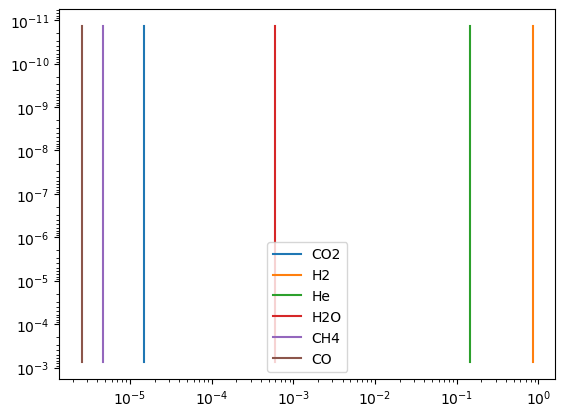

In [43]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

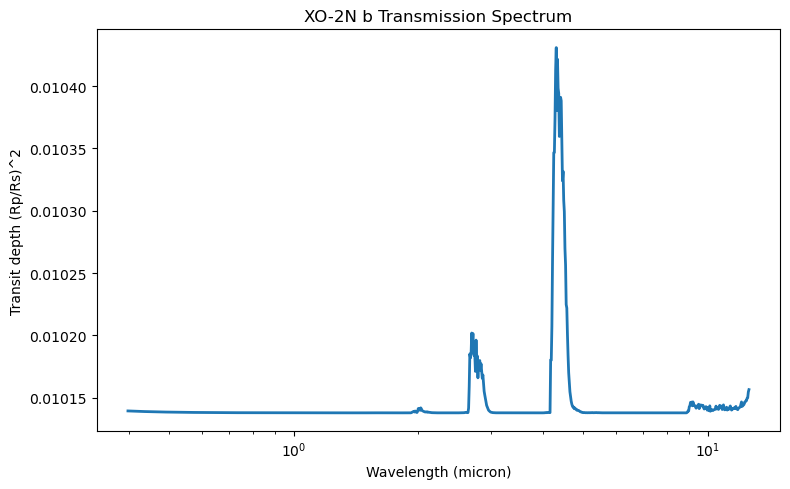

'native_grid, rprs, tau, _ = res\n\nfull_fig = plt.figure()\nplt.plot(np.log10(10000/native_grid),rprs)\nplt.show()'

In [44]:
#task A
from taurex.binning import SimpleBinner
wngrid = np.sort(10000 / np.logspace(-0.4, 1.1, 1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_depth, _, _ = bn.bin_model((native_grid, depth, tau, None))

plt.figure(figsize=(8,5))
plt.plot(10000/bin_wn, bin_depth, lw=2)
plt.xscale("log")
plt.xlabel("Wavelength (micron)")
plt.ylabel("Transit depth (Rp/Rs)^2")
plt.title("XO-2N b Transmission Spectrum")
plt.tight_layout()

plt.savefig("XO-2Nb_assignment3_taskA_spectrum.png", dpi=300)
plt.show()

'''native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()'''

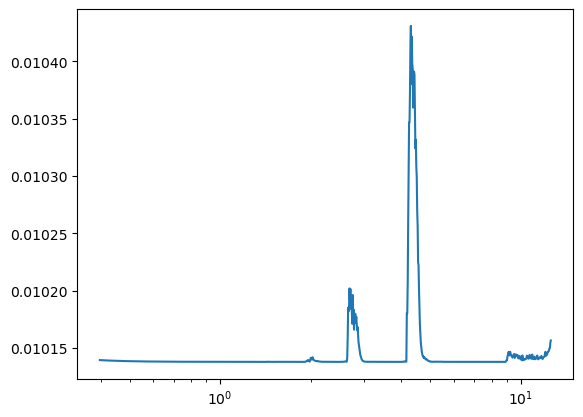

In [45]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()

In [46]:
#task A
with open("XO-2Nb_assignment3_taskA_parameters.txt", "w") as f:
    f.write("Planet: XO-2N b\n")
    f.write("Model: TauREx Transmission Spectrum\n\n")

    f.write("Planet parameters:\n")
    f.write("  Radius: 0.97 Rj\n")
    f.write("  Mass:   0.62 Mj\n\n")

    f.write("Star parameters:\n")
    f.write("  Temperature: 5290 K\n")
    f.write("  Radius:      0.99 Rsun\n\n")

    f.write("Atmosphere:\n")
    f.write(f"  H2O: {h2o_ab:.2e}\n")
    f.write(f"  CH4: {ch4_ab:.2e}\n")
    f.write(f"  CO2: {co2_ab:.2e}\n")
    f.write(f"  CO:  {co_ab:.2e}\n\n")

    f.write("Error model:\n")
    f.write("  Constant 10 ppm\n")
